## Package Dependence

+ DifferentialEquations / DiffEqSensitivity for ODE solver
+ ForwardDiff for auto-differentiation

In [1]:
using Arrhenius
using LinearAlgebra
using DifferentialEquations
using ForwardDiff
using DiffEqSensitivity
using Plots
using DelimitedFiles
using Profile

## Load cantera data
For comprisions, we run the simulation in Canetra and save it to file.

In [2]:
cantera_data = readdlm("pyrolysis.dat")
ct_ts= cantera_data[:, 1]
ct_T = cantera_data[:, 2]
ct_Y = cantera_data[:, 3:end];

## Create a struct of solution

Similar to Cantera, we create a struct of solution to store all of the kinetic and thermodynamic data.

Those infomation are stored in the .yaml file. In addition, to preclude the need of re-invent wheels for interpreting .yaml files, we also rely on the package of ReacTorch to interpret the mechanism and save them into a .npy file.

Here is a complete list of keys of the solution [source code](https://github.com/DENG-MIT/Arrhenius.jl/blob/a6e77fa501f8e1bfb0b4bd244b507f0bc10f1f8c/src/DataStructure.jl#L29)

```Julia
struct Reaction
    product_stoich_coeffs::Array{Float64, 2}
    reactant_stoich_coeffs::Array{Float64, 2}
    reactant_orders::Array{Float64, 2}
    is_reversible::Array{Bool, 1}
    Arrhenius_coeffs::Array{Float64, 2}
    Arrhenius_A0::Array{Float64, 1}
    Arrhenius_b0::Array{Float64, 1}
    Arrhenius_Ea0::Array{Float64, 1}
    Troe_A::Array{Float64, 1}
    Troe_T1::Array{Float64, 1}
    Troe_T2::Array{Float64, 1}
    Troe_T3::Array{Float64, 1}
    index_three_body::Array{Int64, 1}
    index_falloff::Array{Int64, 1}
    efficiencies_coeffs::Array{Float64, 2}
    i_reactant::Array{Array{Int64, 1},1}
    i_product::Array{Array{Int64, 1},1}
    n_reactions::Int64
    vk::Array{Float64, 2}
    vk_sum::Array{Float64, 1}
end

struct Thermo
    nasa_low::Array{Float64, 2}
    nasa_high::Array{Float64, 2}
end

struct Solution
    n_species::Int64
    n_reactions::Int64
    MW::Vector{Float64}
    species_names::Vector{String}
    thermo::Thermo
    reaction::Reaction
end
```

In [3]:
gas = CreateSolution("../../mechanism/JP10skeletal.yaml")

Arrhenius.Solution(40, 232, [136.238, 2.016, 15.035, 16.043, 28.054, 26.037999999999997, 42.081, 78.114, 92.14099999999999, 66.103  …  41.073, 56.064, 53.083999999999996, 56.108, 80.08599999999998, 81.094, 65.095, 77.10600000000001, 93.105, 28.014], ["C10H16", "H2", "CH3", "CH4", "C2H4", "C2H2", "C3H6", "C6H6", "C6H5CH3", "C5H6"  …  "aC3H5", "C2H3CHO", "c-C4H5", "C4H81", "C5H4O", "C5H5O(2,4)", "C5H5", "C6H5", "C6H5O", "N2"], Arrhenius.Thermo([2.85948209 0.00235106377 … -11781.5129 17.6905061; 2.34433112 0.00798052075 … -917.935173 0.683010238; … ; -0.466204455 0.0413443975 … 4778.58391 27.6990274; 3.298677 0.0014082404 … -1020.8999 3.950372], [18.1657042 0.051774734 … -20050.6251 -82.4466452; 3.3372792 -4.94024731e-5 … -950.158922 -3.20502331; … ; 13.722172 0.0174688771 … 287.274751 -48.818168; 2.92664 0.0014879768 … -922.7977 5.980528]), Arrhenius.Reaction([0.0 0.0 … 0.0 0.0; 0.407143 1.367353 … 0.0 1.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [1.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;

In [4]:
ns = gas.n_species
nr = gas.n_reactions

232

In [5]:
gas.species_names

40-element Array{String,1}:
 "C10H16"
 "H2"
 "CH3"
 "CH4"
 "C2H4"
 "C2H2"
 "C3H6"
 "C6H6"
 "C6H5CH3"
 "C5H6"
 "O2"
 "CO"
 "pC3H4"
 ⋮
 "CH2CHO"
 "C3H3"
 "aC3H5"
 "C2H3CHO"
 "c-C4H5"
 "C4H81"
 "C5H4O"
 "C5H5O(2,4)"
 "C5H5"
 "C6H5"
 "C6H5O"
 "N2"

## Impliment governing equations

The core functionality of Arrhenius.jl is interpreting chemical kinetic models, and compute the reaction source term. Most of combustion simulations involves of equations on top of reaction source term.

This example simulate the pyrolysis under constant pressure conditions. While the pressure is fixed, we need equations to describe the changes of species concentrations and temperature. Species concentrations can be represented in three ways: mass fraction, mole fractions and mole concentrations. Most of combustion software impletes the governing equations using mass fraction or mass fractions divided by density.

Therefore, we create arrays to host the initial values of the ODEs.

In [6]:
Y0 = zeros(ns)
Y0[species_index(gas, "C10H16")] = 0.05
Y0[species_index(gas, "N2")] = 0.95
T0 = 1200.0   #K
P = one_atm
u0 = vcat(Y0, T0);

One of the cool features of Julia language is that writing julia code is like write math equations. Once you know the governing equations, it is easy to implement the governing equations. In the governing equations, we have some magic functions to derive all relevent internal variables from the exposed variables of mass fraction Y and temperature T.

Notebly

* mean molecular weights `mean_MW = 1. / dot(Y, 1 ./ gas.MW)`
* density
* mass fraction to mole fraction Y2X
* mass fraction to mole concentration Y2C
* cp_mole
* h_mole (enthapy)
* S0 (entropy)
* wdot = dC/dt
* Ydot = dY/dt
* Tdot = dT/dt

In [7]:
@inbounds function dudt!(du, u, p, t)
    T = u[end]
    Y = @view(u[1:ns])
    mean_MW = 1. / dot(Y, 1 ./ gas.MW)
    ρ_mass = P / R / T * mean_MW
    X = Y2X(gas, Y, mean_MW)
    C = Y2C(gas, Y, ρ_mass)
    cp_mole, cp_mass = get_cp(gas, T, X, mean_MW)
    h_mole = get_H(gas, T, Y, X)
    S0 = get_S(gas, T, P, X)
    wdot = wdot_func(gas.reaction, T, C, S0, h_mole)
    Ydot = wdot / ρ_mass .* gas.MW
    Tdot = -dot(h_mole, wdot) / ρ_mass / cp_mass
    du .= vcat(Ydot, Tdot)
end

dudt! (generic function with 1 method)

## Solve the governing equations

In [8]:
tspan = [0.0, 0.07];
prob = ODEProblem(dudt!, u0, tspan);
sol = solve(prob, TRBDF2(), reltol=1e-6, abstol=1e-9);

## Validation with Cantera

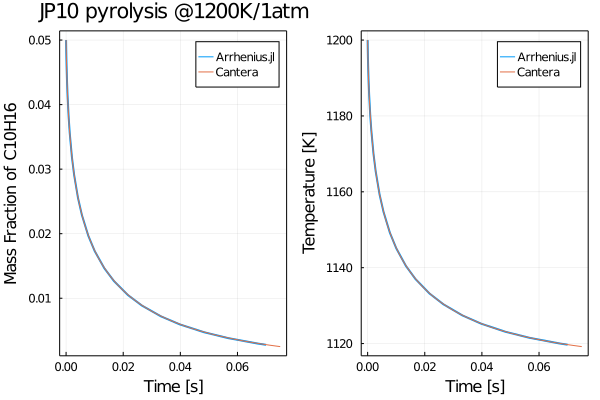

In [9]:
plt = plot(sol.t, sol[species_index(gas, "C10H16"), :], lw=2, label="Arrhenius.jl");
plot!(plt, ct_ts, ct_Y[:, species_index(gas, "C10H16")], label="Cantera")
ylabel!(plt, "Mass Fraction of C10H16")
xlabel!(plt, "Time [s]")
pltT = plot(sol.t, sol[end, :], lw=2, label="Arrhenius.jl");
plot!(pltT, ct_ts, ct_T, label="Cantera")
ylabel!(pltT, "Temperature [K]")
xlabel!(pltT, "Time [s]")
title!(plt, "JP10 pyrolysis @1200K/1atm")
pltsum = plot(plt, pltT, legend=true, framestyle=:box)

## AD across the ODE solver

One of the most important motivation for Arrhenius.jl is bring convinient differential programing to combustion research community. While sensitivity analysis has been widely used in combustion community for identify controlling processes, the AD offers us far more benefit than analyzing. With AD, when can accurately compute the gradient of quantity of initerest to model parameters and then employ gradient descent to optimize the model and designs.

Such benefits are now avaliable before since computing gradient with finite difference will lead to inaccurate gradients and it is in effcient.

## Choice of ODE solver

By fault, `Rosenbrock23()` and `TRBDF()` are recommanded. Since the backward pass could be high-dimensional, TRBDF could be more effcient.

You can use `@time` to profile the code time and memory cost. Pay attentions to the memory allocation.

## Choice of AD

Currently, Arrhenius.jl only supports forward-mode AD, which is also the most effcient approach when the number of parameters is in the order of hundreds.

In [10]:
# sensealg = InterpolatingAdjoint(autojacvec=ReverseDiffVJP(false))
# sensealg = BacksolveAdjoint(autojacvec=ReverseDiffVJP(false))
sensealg = ForwardDiffSensitivity()
# sensealg = SensitivityADPassThrough()
# sensealg = ForwardSensitivity(autojacvec=true)
# alg = Rosenbrock23()
alg = TRBDF2()
function fsol(u0)
    sol = solve(prob, u0=u0, alg, tspan = (0.0, 7.e-2),
                reltol=1e-3, abstol=1e-6, sensealg=sensealg)
    return sol[end, end]
end
u0[end] = 1200.0 + rand()
println("timing ode solver ...")
@time fsol(u0)
@time fsol(u0)
@time ForwardDiff.gradient(fsol, u0)
@time ForwardDiff.gradient(fsol, u0)

timing ode solver ...
  0.393081 seconds (618.49 k allocations: 45.289 MiB, 7.98% gc time)
  0.030482 seconds (16.72 k allocations: 11.618 MiB)
 38.235942 seconds (91.11 M allocations: 4.823 GiB, 4.33% gc time)
  1.374211 seconds (183.25 k allocations: 864.085 MiB, 8.51% gc time)


41-element Array{Float64,1}:
 -1119.8574895617853
  1353.705959536618
  8765.556509413618
   191.04469706931945
    53.25684170163964
   624.233024296034
    90.74277729536885
   136.4497149398903
   211.969394439409
   -84.07114713791519
  3563.712928856195
    59.84092050750525
   786.627297761222
     ⋮
  3587.063646970974
  2137.9457017314057
   121.13624590527634
   266.0152528965665
   590.2980881146284
  -913.6475062263189
   385.52979611217586
   975.3694011639074
  1967.8137267915197
   120.11223533870916
    59.02835285276966
     0.776779099512288